In [2]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
import matplotlib as mpl
import sys



from nbodykit.lab import *
from nbodykit import setup_logging, style

In [3]:
"""Create k^2 in box (nc x nc x nc)"""
def k_box(nc,L):
    kfac = 2.*np.pi/L
    k= np.fft.fftfreq(nc,d=1./nc/kfac) #d controls spacing
    a = np.array(list(itertools.product(range(nc),repeat=3))) #nc x nc x nc combinations
    a = np.reshape(a,(nc,nc,nc,3)) #1 grid cell 3 coordinates
    k2=(k[a]**2).sum(axis=-1) # each grid cell is sum of squares of coordinates
    return (np.sqrt(k2))


##################### alternative Metin 
"""Function to calculate the power spectrum in spherical bins"""
def measure_pk(s1, s2, k, kbin):
    fs1 = np.fft.fftn(s1)
    fs2 = np.fft.fftn(s2)
    power = np.zeros(len(kbin)-1)
    center_k = (kbin[:-1] + kbin[1:]) / 2
    #divide k array into kbin
    for i in range(len(kbin[:-1])):
        xind,yind,zind = np.where((k>=kbin[i])*(k<kbin[i+1])) # 3D index of all k values at bin[i]
        power[i] = (((fs1[xind,yind,zind].real*fs2[xind,yind,zind].real)+(fs1[xind,yind,zind].imag*fs2[xind,yind,zind].imag))).mean()#*(L**3/nc**6) 
    return (center_k,power)

In [4]:
"""define file, number of cells, box sizes etc"""
#BIRTH
nc_birth = 256
L_birth = 480.
file_in = '/gpfs02/work/metin/birth/multi_2/dmlcZ_2300.dat'
dm_birth = np.fromfile(file_in,dtype=np.float32).reshape((nc_birth,nc_birth,nc_birth))

In [5]:
#nyx
dm_n = np.load("nyx1000_512.npy") -1.
nc_n = 512
L_n = 100.

In [6]:
Nb = 100
#birth
k_birth = k_box(nc_birth,L_birth)
kmin_birth = 2.*np.pi/L_birth
kmax_birth = k_birth.max()
kbin_birth = np.linspace(kmin_birth,kmax_birth,Nb) #kmin = 2*pi/L, kmax from k^2 
#nyx
k_n = k_box(nc_n,L_n)
kmin_n = 2.*np.pi/L_n
kmax_n = k_n.max()
kbin_n = np.linspace(kmin_n,kmax_n,Nb) #kmin = 2*pi/L, kmax from k^2 


In [7]:
k_bin_birth, power_birth = measure_pk(dm_birth,dm_birth,k_birth,kbin_birth)

In [8]:
k_bin_n, power_n = measure_pk(dm_n,dm_n,k_n,kbin_n)

In [9]:
mesh_birth = ArrayMesh(dm_birth,BoxSize=L_birth)
#r_birth = FFTPower(mesh_birth, mode='1d', dk=0.005, kmin=1e-2)
r_birth = FFTPower(mesh_birth, mode='1d')
Pk_birth = r_birth.power

In [10]:
mesh_n = ArrayMesh(dm_n,BoxSize=L_n)
r_n = FFTPower(mesh_n, mode='1d')
Pk_n = r_n.power

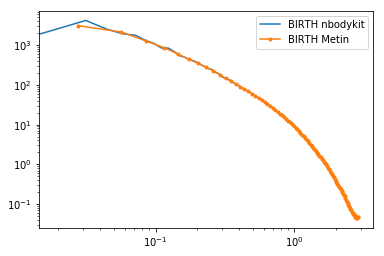

In [14]:
plt.loglog(Pk_birth['k'], Pk_birth['power'].real,label="BIRTH nbodykit")
plt.loglog(k_bin_birth,power_birth*L_birth**3/nc_birth**6,marker='.',label="BIRTH Metin")
plt.legend()
plt.show()

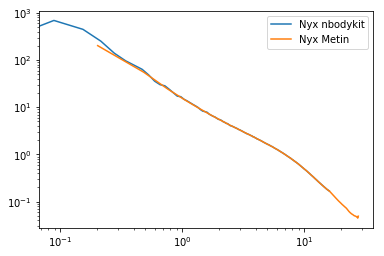

In [15]:
plt.loglog(Pk_n['k'], Pk_n['power'].real,label="Nyx nbodykit")
plt.loglog(k_bin_n,power_n*L_n**3/nc_n**6,label="Nyx Metin")
plt.legend()
plt.show()


In [20]:
# Compute power spectrum for 2Mpc/h binned Nyx box and smoothed Nyx
gauss_sm = 3. #Mpc/h smoothing
dx_n = L_n/nc_n
nc_n_coarse = 50
dm_n_sm = scipy.ndimage.gaussian_filter(dm_n, gauss_sm/dx_n)#, mode='wrap')

mesh_n_sm = ArrayMesh(dm_n_sm,BoxSize=L_n)
r_n_sm = FFTPower(mesh_n_sm, mode='1d')
Pk_n_sm = r_n_sm.power


In [22]:
k_bin_n, power_n_sm = measure_pk(dm_n_sm,dm_n_sm,k_n,kbin_n)

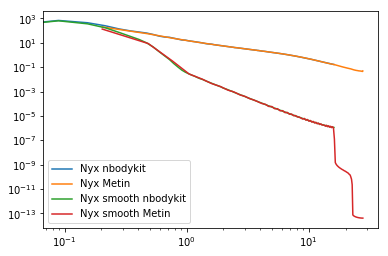

In [25]:
plt.loglog(Pk_n['k'], Pk_n['power'].real,label="Nyx nbodykit")
plt.loglog(k_bin_n,power_n*L_n**3/nc_n**6,label="Nyx Metin")
plt.loglog(Pk_n_sm['k'], Pk_n_sm['power'].real,label="Nyx smooth nbodykit")
plt.loglog(k_bin_n,power_n_sm*L_n**3/nc_n**6,label="Nyx smooth Metin")
plt.legend()
plt.show()

In [28]:
dm_n_sm_coarse = scipy.ndimage.zoom(dm_n_sm, nc_n_coarse/nc_n) 


In [30]:
mesh_n_sm_coarse = ArrayMesh(dm_n_sm_coarse,BoxSize=L_n)
r_n_sm_coarse = FFTPower(mesh_n_sm_coarse, mode='1d')
Pk_n_sm_coarse = r_n_sm_coarse.power



In [36]:
k_n_coarse = k_box(nc_n_coarse,L_n)
kmin_n_coarse = 2.*np.pi/L_n
kmax_n_coarse = k_n_coarse.max()
kbin_n_sm_coarse = np.linspace(kmin_n_coarse,kmax_n_coarse,Nb) #kmin = 2*pi/L, kmax from k^2 

k_bin_n_sm_coarse, power_n_sm_coarse = measure_pk(dm_n_sm_coarse,dm_n_sm_coarse,k_n_coarse,kbin_n_sm_coarse)

/home/metin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/home/metin/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


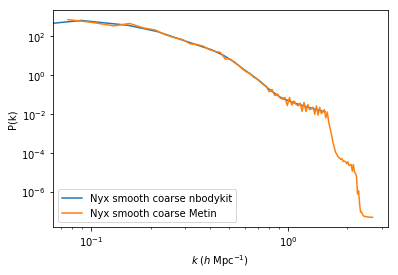

In [42]:
#plt.loglog(Pk_n['k'], Pk_n['power'].real,label="Nyx nbodykit")
#plt.loglog(Pk_n_sm['k'], Pk_n_sm['power'].real,label="Nyx smooth nbodykit")
plt.loglog(Pk_n_sm_coarse['k'], Pk_n_sm_coarse['power'].real,label="Nyx smooth coarse nbodykit")
#plt.loglog(k_bin_n,power_n*L_n**3/nc_n**6,label="Nyx Metin")
#plt.loglog(k_bin_n,power_n_sm*L_n**3/nc_n**6,label="Nyx smooth Metin")
plt.loglog(k_bin_n_sm_coarse,power_n_sm_coarse*L_n**3/nc_n_coarse**6,label="Nyx smooth coarse Metin")
plt.ylabel(r'P(k)')
plt.xlabel(r'$k\; (h\; \mathrm{Mpc}^{-1})$')
plt.legend()
plt.show()